In [1]:
from modelarts.session import Session
session = Session()

session.download_data(
    bucket_path="modelarts-labs/notebook/DL_image_recognition/image_recognition.tar.gz",
    path="./image_recognition.tar.gz")

# 使用tar命令解压资源包
!tar xf ./image_recognition.tar.gz

# 清理压缩包
!rm -f ./image_recognition.tar.gz

Successfully download file modelarts-labs/notebook/DL_image_recognition/image_recognition.tar.gz from OBS to local ./image_recognition.tar.gz
tar: data: Cannot utime: Operation not permitted
tar: data: Cannot change mode to rwsr-s---: Operation not permitted
tar: Exiting with failure status due to previous errors


In [3]:
import os, cv2, random
import numpy as np
import pandas as pd

# 画图工具
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from keras.models import Sequential

from keras.models import Model, load_model
from keras.utils import layer_utils
from keras.utils import np_utils

from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.optimizers import Adamax
from keras.optimizers import Adagrad
from keras.optimizers import SGD
from keras.callbacks import Callback, EarlyStopping, TensorBoard

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.applications.inception_v3 import InceptionV3

from keras import backend as K
K.set_image_data_format('channels_last')

In [4]:
DATA_DIR = './data/' # 数据集路径

ROWS = 299
COLS = 299
CHANNELS = 3

image_file_names = [DATA_DIR+i for i in os.listdir(DATA_DIR)] 
dogs = [DATA_DIR+i for i in os.listdir(DATA_DIR) if 'dog' in i]
cats = [DATA_DIR+i for i in os.listdir(DATA_DIR) if 'cat' in i]

# 数据洗牌
random.shuffle(image_file_names)

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) # 彩色模式读取图像
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prep_data(image_file_names):
    count = len(image_file_names)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)
    
    for i, image_file in enumerate(image_file_names):
        image = read_image(image_file)
        data[i] = image
        if i%1000 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

# 读取图片至内存
images = prep_data(image_file_names)

Processed 0 of 25000
Processed 1000 of 25000
Processed 2000 of 25000
Processed 3000 of 25000
Processed 4000 of 25000
Processed 5000 of 25000
Processed 6000 of 25000
Processed 7000 of 25000
Processed 8000 of 25000
Processed 9000 of 25000
Processed 10000 of 25000
Processed 11000 of 25000
Processed 12000 of 25000
Processed 13000 of 25000
Processed 14000 of 25000
Processed 15000 of 25000
Processed 16000 of 25000
Processed 17000 of 25000
Processed 18000 of 25000
Processed 19000 of 25000
Processed 20000 of 25000
Processed 21000 of 25000
Processed 22000 of 25000
Processed 23000 of 25000
Processed 24000 of 25000


In [5]:
labels = []
for i in image_file_names:
    if 'dog' in i:
        labels.append(0)
    else:
        labels.append(1)
        
# 将标签做热点处理
labels = np_utils.to_categorical(labels, 2)
# 切分数据集
train_data, test_data, train_label, test_label = train_test_split(images, labels, test_size=0.25, random_state=10)
#train_data, validate_data, train_label, validate_label = train_test_split(train_data, train_label, test_size=0.25, random_state=10)

#sns.countplot(labels)
for i in range(10):
    print(labels[i])
    print(image_file_names[i])

[1. 0.]
./data/dog.5695.jpg
[1. 0.]
./data/dog.6574.jpg
[1. 0.]
./data/dog.11378.jpg
[1. 0.]
./data/dog.6553.jpg
[1. 0.]
./data/dog.4932.jpg
[1. 0.]
./data/dog.11924.jpg
[0. 1.]
./data/cat.11626.jpg
[1. 0.]
./data/dog.7771.jpg
[1. 0.]
./data/dog.903.jpg
[1. 0.]
./data/dog.268.jpg


In [6]:
train_data, test_data, train_label, test_label = train_test_split(images, labels, test_size=0.25, random_state=10)

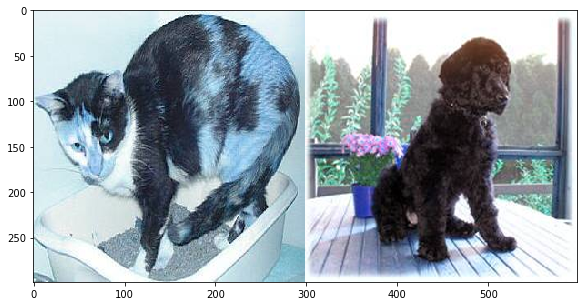

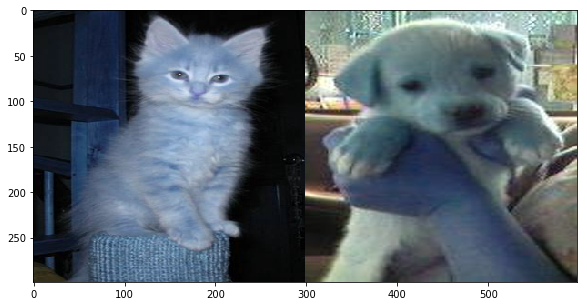

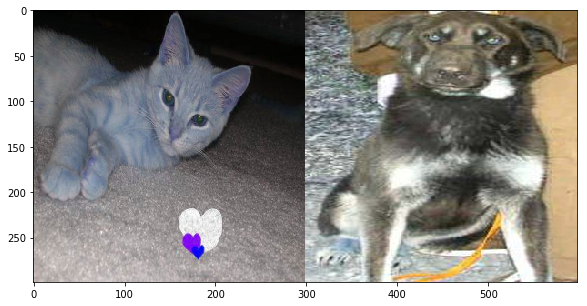

In [7]:
def show_cats_and_dogs(idx):
    cat = read_image(cats[idx])
    dog = read_image(dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,3):
    show_cats_and_dogs(idx)


In [26]:
#初始化InceptionV3基准模型
base_model = InceptionV3(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, classes=1000)



96116736/96112376 [==============================] - 252s 3us/step


In [29]:
x = base_model.output
#添加自己的全链接分类层
predictions = Dense(2, activation='softmax')(x)


In [30]:
#训练模型
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [31]:
# 构建神经网络
optimizer = RMSprop(lr=1e-4) # 优化器使用RMSprop, 设置学习率是1e-4
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
#训练相关参数
epochs = 50 # 训练轮数
batch_size = 20 # 批大小

# Loss记录
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

# early stopping策略
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')   

def run_catdog():
    history = LossHistory()
    
    # 开始训练
    model.fit(
        train_data, 
        train_label, 
        batch_size=batch_size, 
        epochs=epochs,
        validation_split=0.25,  # 训练数据中，抽取25%的数据作为验证数据
        verbose=2,
        shuffle=True,
        callbacks=[history, early_stopping]) 
    
    return  history

In [33]:
#开始训练
history = run_catdog()

Train on 14062 samples, validate on 4688 samples
Epoch 1/50
 - 188s - loss: 0.6016 - acc: 0.9674 - val_loss: 0.5684 - val_acc: 0.9814
Epoch 2/50
 - 174s - loss: 0.5421 - acc: 0.9777 - val_loss: 0.5150 - val_acc: 0.9806
Epoch 3/50
 - 173s - loss: 0.4875 - acc: 0.9853 - val_loss: 0.4649 - val_acc: 0.9821
Epoch 4/50
 - 175s - loss: 0.4393 - acc: 0.9860 - val_loss: 0.4198 - val_acc: 0.9814
Epoch 5/50
 - 175s - loss: 0.3948 - acc: 0.9874 - val_loss: 0.3826 - val_acc: 0.9776
Epoch 6/50
 - 174s - loss: 0.3510 - acc: 0.9918 - val_loss: 0.3399 - val_acc: 0.9834
Epoch 7/50
 - 173s - loss: 0.3132 - acc: 0.9928 - val_loss: 0.3079 - val_acc: 0.9823
Epoch 8/50
 - 173s - loss: 0.2794 - acc: 0.9937 - val_loss: 0.2783 - val_acc: 0.9819
Epoch 9/50
 - 173s - loss: 0.2470 - acc: 0.9955 - val_loss: 0.2578 - val_acc: 0.9774
Epoch 10/50
 - 175s - loss: 0.2195 - acc: 0.9960 - val_loss: 0.2271 - val_acc: 0.9823
Epoch 11/50
 - 174s - loss: 0.1929 - acc: 0.9973 - val_loss: 0.2048 - val_acc: 0.9823
Epoch 12/50
 -

In [34]:
# 训练好的模型可以保存起来，永久使用
OUTPUT = 'output'
if not os.path.exists(OUTPUT):
    os.mkdir(OUTPUT)
model.save(os.path.join(OUTPUT, 'modelInception3.h5'))

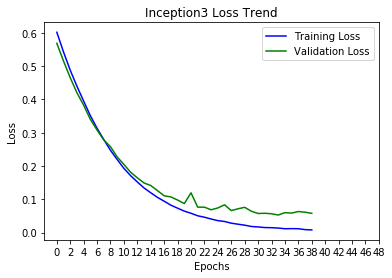

In [35]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Inception3 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0, epochs)[0::2])
plt.legend()
plt.show()

[0.994551   0.00544902]
I am 99.46% sure this is a Dog


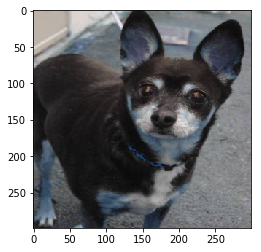

In [36]:
# 预测测试集
predictions = model.predict(test_data, verbose=0)
for i in range(0,1):
    if predictions[i, 0] >= 0.5:         
        print(predictions[i, :])
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print(predictions[i, :])
        print('I am {:.2%} sure this is a Cat'.format(1 - predictions[i][0]))        
    plt.imshow(test_data[i])
    plt.show()

In [39]:
# 预测测试集
predictions = model.predict(test_data, verbose=0)
# 评估模型准确度
predictions_test = []
test_label_test = []
for p in predictions:

    if int(round(p[0])) == 1:
        predictions_test.append(1)
    else:
        predictions_test.append(0)
for t in test_label:
    if int(t[0]) == 1:
        test_label_test.append(1)
    else:
        test_label_test.append(0)
acc = accuracy_score(test_label_test, predictions_test)

print('训练得到的猫狗识别模型的准确度是：%f' % acc)

训练得到的猫狗识别模型的准确度是：0.988800
